Example notebook to demonstrate how to make diagnostic plots using built in methods  

In [11]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt

from gw_eccentricity import get_available_methods
from gw_eccentricity import measure_eccentricity
from gw_eccentricity.load_data import load_waveform
from gw_eccentricity.gw_eccentricity import compute_errors_between_methods

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import glob
import matplotlib.pyplot as plt

In [42]:
eob_waveforms_set1 = sorted(glob.glob("../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_*_Momega00.010_meanAno1.571.h5"))

In [44]:
def compute_errors(method1, method2, waveform_path, zeroecc_waveform_path):
    waveform_keywords = {
        "filepath": waveform_path,
        "filepath_zero_ecc": zeroecc_waveform_path,
        "include_zero_ecc": True}
    dataDict = load_waveform(catalog="EOB", **waveform_keywords)
    tref_vec = dataDict["t"]
    tref_out1, ecc_vec1, mean_ano_vec1, gwecc_obj1 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method1, 
        return_gwecc_object=True,
        extra_kwargs={"debug": False})
    tref_out2, ecc_vec2, mean_ano_vec2, gwecc_obj2 = measure_eccentricity(
        tref_in=tref_vec,
        dataDict=dataDict,
        method=method2, 
        return_gwecc_object=True,
        extra_kwargs={"debug": False})
    t, ecc_errors, mean_ano_errors = compute_errors_between_methods(gwecc_obj1, gwecc_obj2)
    
    return t, ecc_errors, mean_ano_errors, gwecc_obj1, gwecc_obj2

In [45]:
zeroecc_path_set1 = "../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", eob_waveforms_set1[140], zeroecc_path_set1)

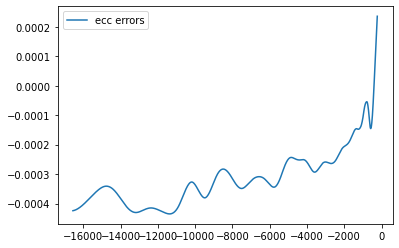

In [46]:
plt.plot(t, ecc_errs, label="ecc errors")
plt.legend()

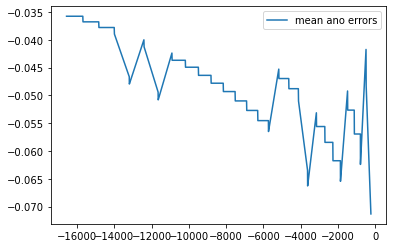

In [47]:
plt.plot(t, mean_ano_errs, label="mean ano errors")
plt.legend()

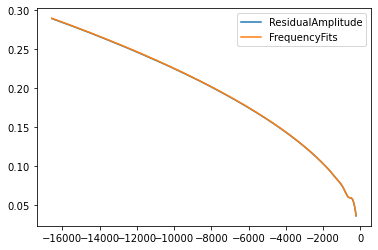

In [48]:
plt.plot(gwecc_obj1.tref_out, gwecc_obj1.ecc_ref, label=gwecc_obj1.method)
plt.plot(gwecc_obj2.tref_out, gwecc_obj2.ecc_ref, label=gwecc_obj2.method)
plt.legend()

### Loop over all eob waveforms in set 1 and compute the max error in eccentricity

In [70]:
import re
from tqdm import tqdm
import numpy as np

In [75]:
ecc_max_errs = []
t_max_errs = []
eccs = []
zeroecc_path_set1 = "../data/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002_meanAno1.571.h5"
for waveform in tqdm(eob_waveforms_set1):
    # get the ecc from waveform path string
    ecc = re.search(".\d{10}", waveform)[0]
    eccs.append(float(ecc))
    t, ecc_errs, mean_ano_errs, gwecc_obj1, gwecc_obj2 = compute_errors("ResidualAmplitude", "FrequencyFits", waveform, zeroecc_path_set1)
    ecc_max_errs.append(max(np.abs(ecc_errs)))
    t_max_errs.append(t[np.abs(ecc_errs).argmax()])

  0%|                                                                                                                                                                                      | 0/150 [00:00<?, ?it/s]/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase d

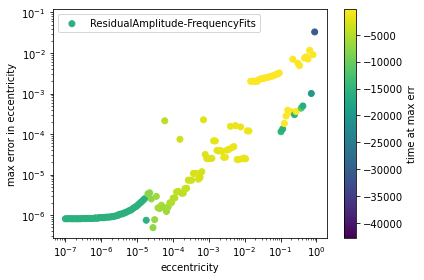

In [81]:
plt.scatter(eccs, ecc_max_errs, c=t_max_errs, label=f"{gwecc_obj1.method}-{gwecc_obj2.method}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("eccentricity")
plt.ylabel("max error in eccentricity")
plt.colorbar(label="time at max err")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(f"max_ecc_erros_{gwecc_obj1.method}_{gwecc_obj2.method}.png")